<a href="https://colab.research.google.com/github/eddson90/tareas_data_science/blob/main/statistical-learning-2/proyecto-final/parte3/Parte3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Parte 3: Red Neuronal Recurrente (RNN)**

## Proyecto Final: Implementación de Modelos de Deep Learning
---

Statistical Learning II

Universidad Galileo

Eddson Sierra

## Carga de librerías

In [1]:
pip install pickle5


     |████████████████████████████████| 132 kB 12.8 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219329 sha256=02565ea175ff256035a93a30969208a2ae31feb51cd693c59f04e18e1d0f1f78
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [2]:
import pickle5 as pickle

In [60]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
 
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

## Carga de datos y preprocesamiento

#### Carga de datos

In [4]:
images_path = '/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/img_data_file.pkl'
tweet_content_path = '/content/drive/MyDrive/Colab Notebooks/Proyecto Final SL2/Parte2_CNN/tweet_content_file.pkl'

In [5]:
def load_from_pk(file_name):
  pickle_file = open(file_name, "rb")
  #objects = []
  while True:
      try:
          #objects.append(pickle.load(pickle_file))
          salida = pickle.load(pickle_file)
      except EOFError:
          break
  pickle_file.close()

  return salida

In [6]:
images = np.array(load_from_pk(images_path))
captions = np.array(load_from_pk(tweet_content_path)).reshape(-1,1)

In [7]:
images.shape, captions.shape

((5574, 128, 128, 3), (5574, 1))

¡Hola, @TopoGigo6! Gracias por compartir. Pertenece a la familia #Corinnidae probablemente. No son consideradas de importancia médica #NIM✅ Saludos https://t.co/hwXi74WiLs


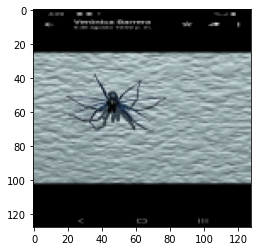

In [8]:
plt.imshow(images[0])
print(captions[0][0])

In [9]:
captions[0:4]

array([['¡Hola, @TopoGigo6! Gracias por compartir. Pertenece a la familia #Corinnidae probablemente. No son consideradas de importancia médica #NIM✅ Saludos https://t.co/hwXi74WiLs'],
       ['¡Hola, @Elwestrand! Gracias por compartir. Pertenece a la familia #Thomisidae, posiblemente del género «Thomisius». No son consideradas de importancia médica #NIM✅ Saludos https://t.co/vUaVvkMHOn'],
       ['¡Hola, @ddiazgar76! Gracias por la consulta. Pertenece a la familia #Oxyopidae, del género #Peucetia probablemente. Se les conoce como arañas lince verdes. No son consideradas de importancia médica #NIM✅ Le hacen falta un par de patas. Saludos https://t.co/UMjC3fIxTF'],
       ['¡Hola, @adukation! Gracias por tu consulta. Pertenece a la familia #Vaejovidae, posiblemente del género #Vaejovis. No son considerados de importancia médica #NIM✅ Sí, es posible que haya más, por el hecho de ser la CDMX zona de distribución natural de 2 especies de este género https://t.co/InMQqvn8xC']],
      dtype='

#### Pasar lista a string

Creamos una función para pasar la lista a string y la aplicamos para cada elemento de la lista de captions (que es una lista en sí misma):

In [10]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [11]:
captions_list_str = []
for i in range(len(captions)):
  caption_str = listToString(captions[i])
  captions_list_str.append(caption_str)

In [12]:
captions_list_str[0:4]

['¡Hola, @TopoGigo6! Gracias por compartir. Pertenece a la familia #Corinnidae probablemente. No son consideradas de importancia médica #NIM✅ Saludos https://t.co/hwXi74WiLs',
 '¡Hola, @Elwestrand! Gracias por compartir. Pertenece a la familia #Thomisidae, posiblemente del género «Thomisius». No son consideradas de importancia médica #NIM✅ Saludos https://t.co/vUaVvkMHOn',
 '¡Hola, @ddiazgar76! Gracias por la consulta. Pertenece a la familia #Oxyopidae, del género #Peucetia probablemente. Se les conoce como arañas lince verdes. No son consideradas de importancia médica #NIM✅ Le hacen falta un par de patas. Saludos https://t.co/UMjC3fIxTF',
 '¡Hola, @adukation! Gracias por tu consulta. Pertenece a la familia #Vaejovidae, posiblemente del género #Vaejovis. No son considerados de importancia médica #NIM✅ Sí, es posible que haya más, por el hecho de ser la CDMX zona de distribución natural de 2 especies de este género https://t.co/InMQqvn8xC']

#### Convertir a minúsculas

Convertimos la lista de captions a minúsculas:

In [13]:
captions_list_clean = []
for i in range(len(captions_list_str)):
        desc = captions_list_str[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        captions_list_clean.append(' '.join(desc))

In [14]:
captions_list_clean[0:4]

['¡hola, @topogigo6! gracias por compartir. pertenece a la familia #corinnidae probablemente. no son consideradas de importancia médica #nim✅ saludos https://t.co/hwxi74wils',
 '¡hola, @elwestrand! gracias por compartir. pertenece a la familia #thomisidae, posiblemente del género «thomisius». no son consideradas de importancia médica #nim✅ saludos https://t.co/vuavvkmhon',
 '¡hola, @ddiazgar76! gracias por la consulta. pertenece a la familia #oxyopidae, del género #peucetia probablemente. se les conoce como arañas lince verdes. no son consideradas de importancia médica #nim✅ le hacen falta un par de patas. saludos https://t.co/umjc3fixtf',
 '¡hola, @adukation! gracias por tu consulta. pertenece a la familia #vaejovidae, posiblemente del género #vaejovis. no son considerados de importancia médica #nim✅ sí, es posible que haya más, por el hecho de ser la cdmx zona de distribución natural de 2 especies de este género https://t.co/inmqqvn8xc']

#### Remover usuario y url con regex

Removemos los nombres de usuario y las urls presentes en las captions a través de expresiones regulares:

In [15]:
import re

In [16]:
patron_user = r"@([a-z]*)?([0-9]*)?(!|_|-)?"
patron_url = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"

In [17]:
for i in range(len(captions_list_clean)):
  try:
    match_user = re.search(patron_user, captions_list_clean[i]).group()
    match_url = re.search(patron_url, captions_list_clean[i]).group()
    captions_list_clean[i] = captions_list_clean[i].replace(match_user,'')
    captions_list_clean[i] = captions_list_clean[i].replace(match_url,'')
  except:
    try:
      match_user = re.search(patron_user, captions_list_clean[i]).group()
      captions_list_clean[i] = captions_list_clean[i].replace(match_user,'')
    except:
      try:
        match_url = re.search(patron_url, captions_list_clean[i]).group()
        captions_list_clean[i] = captions_list_clean[i].replace(match_url,'')
      except:
        continue 

In [18]:
captions_list_clean[0:4]

['¡hola,  gracias por compartir. pertenece a la familia #corinnidae probablemente. no son consideradas de importancia médica #nim✅ saludos ',
 '¡hola,  gracias por compartir. pertenece a la familia #thomisidae, posiblemente del género «thomisius». no son consideradas de importancia médica #nim✅ saludos ',
 '¡hola,  gracias por la consulta. pertenece a la familia #oxyopidae, del género #peucetia probablemente. se les conoce como arañas lince verdes. no son consideradas de importancia médica #nim✅ le hacen falta un par de patas. saludos ',
 '¡hola,  gracias por tu consulta. pertenece a la familia #vaejovidae, posiblemente del género #vaejovis. no son considerados de importancia médica #nim✅ sí, es posible que haya más, por el hecho de ser la cdmx zona de distribución natural de 2 especies de este género ']

### Remoción de emojis

Utilizando la librería demoji, creamos una función que permite extraer los emojis utilizados en un texto y la utilizamos para remover todos los emojis en las captions:

In [19]:
pip install demoji

     |████████████████████████████████| 42 kB 1.1 MB/s 


In [20]:
import demoji
demoji.download_codes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  


In [21]:
for i in range(len(captions_list_clean)):
  try:
    emoji_dict = demoji.findall(captions_list_clean[i])
    for key in emoji_dict:
      captions_list_clean[i] = captions_list_clean[i].replace(key,'')
  except:
    continue

In [22]:
captions_list_clean[0:4]

['¡hola,  gracias por compartir. pertenece a la familia #corinnidae probablemente. no son consideradas de importancia médica #nim saludos ',
 '¡hola,  gracias por compartir. pertenece a la familia #thomisidae, posiblemente del género «thomisius». no son consideradas de importancia médica #nim saludos ',
 '¡hola,  gracias por la consulta. pertenece a la familia #oxyopidae, del género #peucetia probablemente. se les conoce como arañas lince verdes. no son consideradas de importancia médica #nim le hacen falta un par de patas. saludos ',
 '¡hola,  gracias por tu consulta. pertenece a la familia #vaejovidae, posiblemente del género #vaejovis. no son considerados de importancia médica #nim sí, es posible que haya más, por el hecho de ser la cdmx zona de distribución natural de 2 especies de este género ']

### Remover otros signos de puntuación

In [23]:
punc = '''!¡()-[]{};:'"\,<>./?@#$%^&*_~'''
for i in range(len(captions_list_str)):
  for ele in captions_list_clean[i]:
      if ele in punc:
          captions_list_clean[i] = captions_list_clean[i].replace(ele, "")

In [24]:
captions_list_clean[0:4]

['hola  gracias por compartir pertenece a la familia corinnidae probablemente no son consideradas de importancia médica nim saludos ',
 'hola  gracias por compartir pertenece a la familia thomisidae posiblemente del género «thomisius» no son consideradas de importancia médica nim saludos ',
 'hola  gracias por la consulta pertenece a la familia oxyopidae del género peucetia probablemente se les conoce como arañas lince verdes no son consideradas de importancia médica nim le hacen falta un par de patas saludos ',
 'hola  gracias por tu consulta pertenece a la familia vaejovidae posiblemente del género vaejovis no son considerados de importancia médica nim sí es posible que haya más por el hecho de ser la cdmx zona de distribución natural de 2 especies de este género ']

'hola  se trata de una araña de la familia araneidae posiblemente del género wagneriana son arañas bastante llamativas e inofensivas nim '

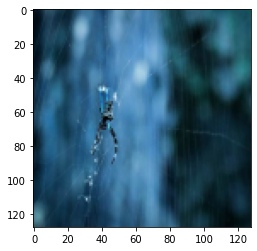

In [25]:
plt.imshow(images[5500])
captions_list_clean[5500]

### Lista de captions y diccionario de imágenes

Creamos un diccionario que relaciona todas las captions con el índice de la imagen correspondiente:

In [33]:
descriptions = {}
for index, caption in enumerate(captions_list_clean):
    descriptions[index] = caption

Creamos un dataframe a partir del diccionario:

In [86]:
data = pd.DataFrame.from_dict(descriptions,orient='index', columns=['caption'])
data['image_index'] = data.index
data = data[['image_index', 'caption']]
data.head()

,image_index,caption
0,0,hola gracias por compartir pertenece a la fam...
1,1,hola gracias por compartir pertenece a la fam...
2,2,hola gracias por la consulta pertenece a la f...
3,3,hola gracias por tu consulta pertenece a la f...
4,4,hola gracias por compartir pertenece a la fam...


Ahora ya tenemos 2 elementos que usaremos después: 
1. Un diccionario de imágenes y sus captions correspondientes, y
2. Un lista de todas las captions

Por facilidad los renombramos:

In [92]:
text_data=captions_list_clean
captions_mapping=descriptions

### Vocabulario

Ahora creamos un vocabulario con todas las palabras únicas que aparecen en las captions:

In [56]:
vocabulario = set()
for key in descriptions.keys():
  vocabulario.update(descriptions[key].split())
print('Tamaño original del vocabulario: '+str(len(vocabulario)))

Tamaño original del vocabulario: 4376


## Separación de datos (Captions)

Definimos una función para separar el diccionario:

In [89]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    all_images = list(caption_data.keys())
    if shuffle:
        np.random.shuffle(all_images)

    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    return training_data, validation_data

In [102]:
train_data, validation_data = train_val_split(captions_mapping)

In [103]:
train_data, test_data = train_val_split(train_data, train_size=0.9)

In [104]:
print("Entrenamiento: ", len(train_data))
print("Validación: ", len(validation_data))
print("Testing:", len(test_data))

Entrenamiento:  4013
Validación:  1115
Testing: 446


## Vectorización de datos (Embeddings)

Importar GloVe

In [ ]:
! pip install glove_python

Crear una matriz de concurrencia:

In [ ]:
import glove
glove_corpus = glove.Corpus()

corpus_sentences = [ 
        [ w.lower() for w in next(corpus_sentence_tokens_gen)] # All lower-case
        for _ in range(0,100*1000) 
    ]

# Fit the co-occurrence matrix using a sliding window of 10 words.
t0 = time.time()
glove_corpus.fit(corpus_sentences, window=10)

print("Dictionary length=%d" % (len(glove_corpus.dictionary),))
print("Co-occurrence calculated in %5.1fsec" % (time.time()-t0, ))

Usando TextVectorization:

In [114]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from keras.models import Sequential

In [132]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=len(vocabulario), ## acá utilizamos el tamaño del vocabulario creado
    output_mode="int",
    output_sequence_length=25,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# aumentado de datos
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

Dataset como objeto de TensorFlow:

In [143]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

In [144]:
cap_dataset = tf.data.Dataset.from_tensor_slices(list(train_data.values())).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )

In [145]:
img_dataset = tf.data.Dataset.from_tensor_slices(images)

In [146]:
dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))

In [147]:
dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)

## Arquitectura

Se utilizará un modelo pre-entrenado:

In [152]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 3s 0us/step


Removemos la capa de Softmax porque necesitamos la salida del feature map:

In [153]:
model_new = Model(model.input, model.layers[-2].output)

## Entrenamiento, validación y selección

## Experimentación y evaluación en data set de pruebas